Epoch:1, Loss:0.9233
Epoch:2, Loss:0.9262
Epoch:3, Loss:0.9267
Epoch:4, Loss:0.9240
Epoch:5, Loss:0.9271
Epoch:6, Loss:0.9252
Epoch:7, Loss:0.9235
Epoch:8, Loss:0.9263
Epoch:9, Loss:0.9265
Epoch:10, Loss:0.9285
Silhouette Score: 0.5125
Davies-Bouldin Index: 0.5260
Calinski-Harabasz Index: 313607.2500


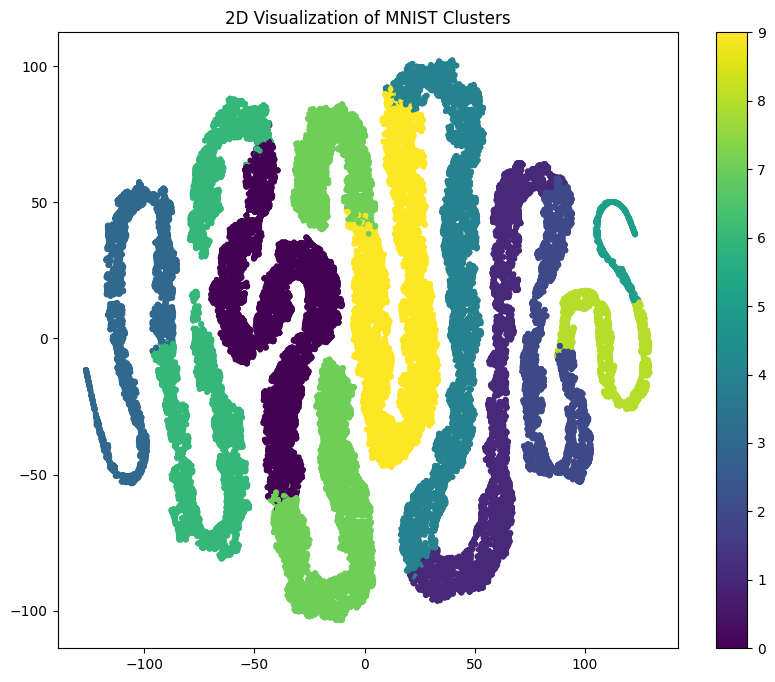

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 1. Define the Autoencoder Model [cite: 11, 12, 13, 14]
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)  # Latent space [cite: 12]
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()  # Output pixels are 0-1
        )

    def forward(self, x):
        encoding = self.encoder(x)
        reconstruction = self.decoder(encoding)
        return reconstruction, encoding

# 2. Load and Preprocess the MNIST Dataset [cite: 5, 7, 8]
input_dim = 28 * 28  # MNIST images are 28x28
encoding_dim = 64  # Latent space dimension [cite: 20, 21]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_dataset, batch_size=256, shuffle=True)

# 3. Initialize the Model, Loss Function, and Optimizer [cite: 32, 33, 34]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available

model = Autoencoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss() # Reconstruction loss [cite: 13]
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Train the Autoencoder [cite: 22, 23, 24]
epochs = 10
for epoch in range(epochs):
    for data, _ in mnist_loader:
        data = data.view(-1, input_dim).to(device)  # Flatten the images
        optimizer.zero_grad()
        reconstruction, _ = model(data)
        loss = criterion(reconstruction, data)
        loss.backward()
        optimizer.step()
    print(f'Epoch:{epoch + 1}, Loss:{loss.item():.4f}')

# 5. Generate Embeddings for Clustering [cite: 10, 21]
model.eval() # Set the model to evaluation mode
embeddings = []
with torch.no_grad():
    for data, _ in mnist_loader:
        data = data.view(-1, input_dim).to(device)
        _, encoding = model(data)
        embeddings.append(encoding.cpu().numpy())

embeddings = np.concatenate(embeddings)  # Concatenate all embeddings

# 6. Apply K-Means Clustering [cite: 21, 25]
n_clusters = 10  # MNIST has 10 digits
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings)
cluster_labels = kmeans.labels_

# 7. Evaluate Clustering Performance [cite: 3, 25]
silhouette_avg = silhouette_score(embeddings, cluster_labels)
db_index = davies_bouldin_score(embeddings, cluster_labels)
ch_index = calinski_harabasz_score(embeddings, cluster_labels)

print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

#8. Visualize
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce dimensionality of embeddings for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.colorbar(scatter)
plt.title('2D Visualization of MNIST Clusters')
plt.show()